# TPFMachine Tutorial 1.1

In [1]:
import numpy as np
import psfmachine as pm
import lightkurve as lk
import matplotlib.pyplot as plt

In [2]:
import warnings
from scipy import sparse
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=sparse.SparseEfficiencyWarning)

## TPFs

In this tutorial we will see in depth how `TPFMachine` creates shape model, time models, and computes PSF and SAP photometry


We'll start downloading 200 TPFs around Kepler-16 observed during quarter 5

In [3]:
tpfs = lk.search_targetpixelfile('Kepler-16', mission='Kepler', quarter=5, 
                                 radius=1000, limit=200, cadence='long'
                                ).download_all(quality_bitmask=None)

Here is a visualization of a single TPF as example

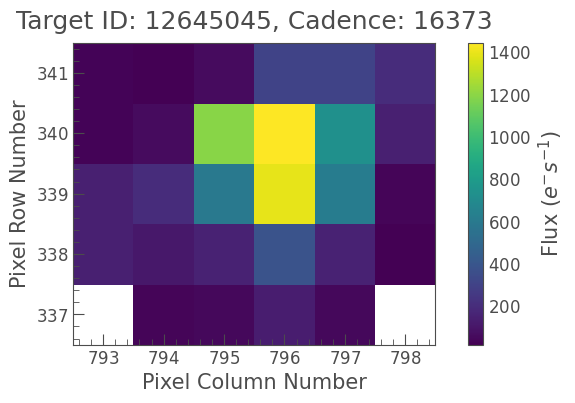

In [4]:
tpfs[52].plot();

## TPFMachine

As explained in the [LFD paper](https://ui.adsabs.harvard.edu/abs/2021AJ....162..107H/abstract), `PSFMachine` performs PSF photometry
of all sources (using Gaia as source catalog) in the TPFs. 
To create a `PSFMachine` object from TPFs, we use the submodule `TPFMachine` that includes useful methods to parse and work with 
TPF data. We'll do this using `pm.TPFMachine.from_TPFs()` which inputs a collection of TPFs. Other inputs to this method are:

* `magnitude_limit` which is the limiting magnitude to query sources in Gaia catalogs
* `dr` is the number data release, e.g. 3 for Gaia EDR3
* \*\*kwargs for `Machine` as listed [here](https://ssdatalab.github.io/psfmachine/machine/#psfmachine.machine.Machine.__init__)

Under the hood, `pm.TPFMachine.from_TPFs()` will parse the TPF data, convert pixels coordinates into WCS, filter saturated pixels, 
removed bad cadences, query Gaia, and return a `Machine` object.

Printing the new `machine` object will tell us how many sources are in the TPFs pixels, the number of cadences, and 
total number of pixel data.

In [5]:
machine = pm.TPFMachine.from_TPFs(tpfs, magnitude_limit=18, dr=3)
machine

TPFMachine (N sources, N times, N pixels): (359, 4486, 8043)

Some important `machine` attributes are:
* `machine.tpfs` and `machine.tpf_meta` have the list of original TPFs and a dictionary with TPF metadata such as quarter, channel, mission, sources in each TPF, etc.
* `machine.sources`: with a pandas.DataFrame containing the source catalog
* `machine.time`: that has a array with time values in MJD
* `flux` and `flux_err`: have the flux and flux error values of each pixel, shape is `[n_times, n_pixels]`
* `ra` and `dec`: have the RA and Dec values of each pixel, shape is `[n_pixels]`
* `column` and `row`: have the column and row values of each pixel, shape is `[n_pixels]`
* `dra` and `ddec`: have the distance in Cartesian space between pixel RA, Dec to each source in `machine.sources`, shape is `[n_sources, npixels]`
* `r` and `phi`: have the distance in Polar space between pixel RA, Dec to each source in `machine.sources`, shape is `[n_sources, npixels]`

You can see the full list of attributes (as a dictionary) doing `machine.__dict__`. Let's see and use some of them as examples:

Here's the source catalog from Gaia:

In [6]:
machine.sources

,designation,ra,dec,parallax,parallax_error,pmra,pmdec,phot_g_mean_flux,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,clean_flag,tpf_id
0,Gaia EDR3 2133262530247167616,289.324552,51.582686,1.616466,0.032562,-2.298416,-11.012768,7062.031645,16.065042,16.800795,15.232625,0,12554848
1,Gaia EDR3 2133263080002987392,289.207900,51.586092,0.504336,0.050699,-3.558866,-7.815627,2738.845449,17.093449,17.545729,16.499073,0,None
2,Gaia EDR3 2133263080003584128,289.205602,51.582282,0.984947,0.017882,-7.581524,-6.793829,20097.434517,14.929515,15.299093,14.393923,0,12554673
3,Gaia EDR3 2133263084302086272,289.194951,51.583371,0.883457,0.019191,-5.343587,-7.699694,16423.362618,15.148711,15.525050,14.608281,0,12554659
4,Gaia EDR3 2133263084302086784,289.196992,51.586797,0.309922,0.017201,-4.139091,-5.795632,20483.462439,14.908858,15.399604,14.256479,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Gaia EDR3 2133492779152324736,288.838971,51.893487,0.821284,0.040056,-6.652471,-2.473718,3941.997142,16.698076,17.246286,15.988624,0,None
355,Gaia EDR3 2133492912292382976,288.893595,51.890141,2.585587,0.015439,-18.046519,-29.085882,530062.957277,11.376548,11.654636,10.933944,0,12689094
356,Gaia EDR3 2133492916591300864,288.889496,51.894211,0.144796,0.069053,-1.658150,-3.073686,1581.248367,17.689867,18.231911,17.057388,0,None
357,Gaia EDR3 2133492916591304320,288.894867,51.896601,0.648541,0.050593,-5.933056,-0.122113,2980.270501,17.001728,17.525383,16.370127,0,None


We can visualize the skymap of TPFs

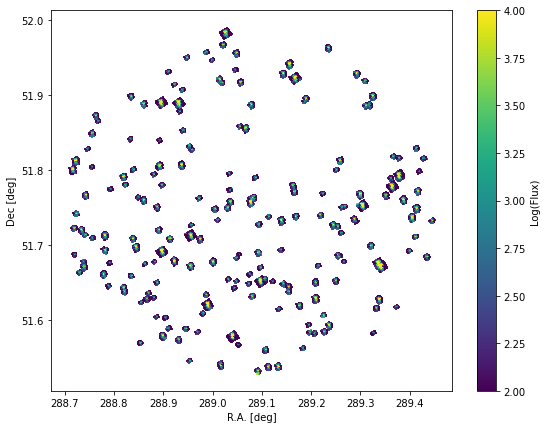

In [7]:
fig = plt.figure(figsize=(9,7))
cbar = plt.scatter(machine.ra, machine.dec, marker="s", s=1, c=np.log10(machine.flux[0]), vmin=2, vmax=4)
fig.colorbar(cbar, label="Log(Flux)")
plt.xlabel("R.A. [deg]")
plt.ylabel("Dec [deg]")
plt.show()

## Fit a PSF model (aka shape model)

`PSFMachine` uses all clean (noon-blended and non-saturated) source (pixels) to build a shape model of the entire scene.
This is done using the `machine.build_shape_model()` method that accepts the following parameters:
* `plot` to create a diagnostic plot with the PSF model in Cartesian and Polar coordinates
* `flux_cut_off` the normalized (time-average flux) flux value at which we stop evaluating the model, default is 1
* `upper_radius_limit` to set the upper limit on the radius at which we assume there is no flux from the source (default is 28'')
* `upper_flux_limit` and `lower_flux_limit` to set the upper and lower limits of flux to filter pixels (helps removing saturated and too faint pixels)

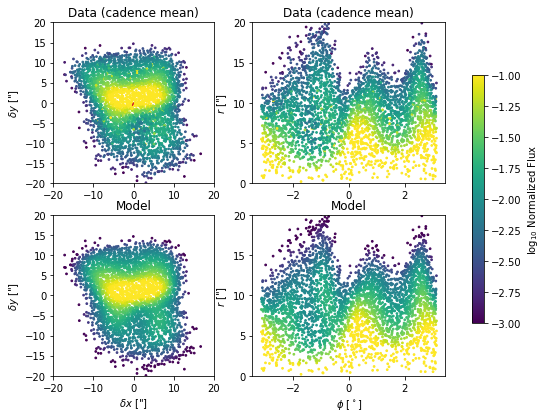

In [8]:
machine.build_shape_model(plot=True, flux_cut_off=1);

We can remove "background" pixels by increasing the `flux_cut_off` value.

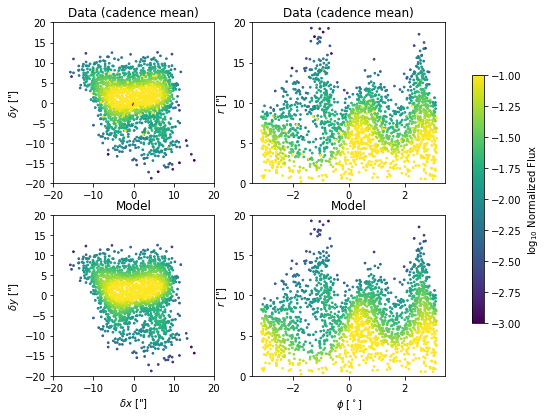

In [9]:
machine.build_shape_model(plot=True, flux_cut_off=10);

A shape model can also be loaded from disk if we are working with Kepler TPFs. The library includes PSF models for each channel
and quarter of observation during Kepler's mission. We can load a shape model for the TPFs we have using
`machine.load_shape_model()`. By default the corresponding channel/quarter model will be load, you can also provide a custom
model (see [Tutorial 20](Tutorial_20_FFI.ipynb) on how to buil and save FFI shape models)

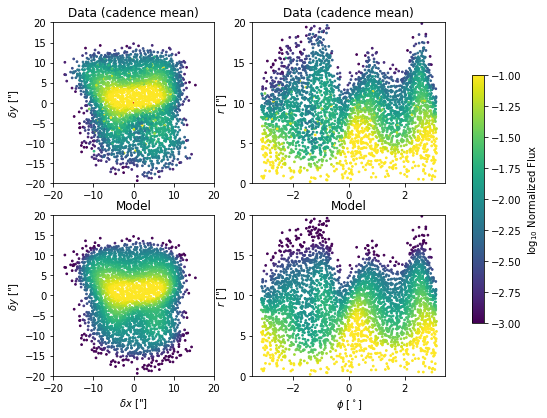

In [10]:
machine.load_shape_model(plot=True);

Either building or loading a shape model leave `machine` in the same state.

One interesting new attribute is `machine.mean_model` that has the mean PSF model for every source in the data. This variable is a 
`scipy.sparse.csr_matrix` and has shape `[n_sources, n_pixels]` and can be used to visualize the PSF model of a source

In [11]:
machine.mean_model

<359x8043 sparse matrix of type '<class 'numpy.float64'>'
	with 5147 stored elements in Compressed Sparse Row format>

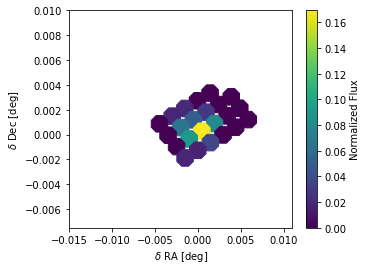

In [12]:
fig = plt.figure(figsize=(5,4))
cbar = plt.scatter(machine.dra[0], machine.ddec[0], 
                   c=machine.mean_model[0].toarray().ravel(), 
                   s=320, marker="8")
fig.colorbar(cbar, label="Normalized Flux")
plt.xlim(-.015, .011)
plt.ylim(-.0075, .01)
plt.xlabel(r"$\delta$ RA [deg]")
plt.ylabel(r"$\delta$ Dec [deg]")
plt.show()

## Fit a time model

As described [here](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-2-kepler-noise-3-seasonal-and-detector-effects.html#2.-Differential-Velocity-Aberration-and-Image-Motion)
Kepler has differential velocity aberration, this means that all sources in a relatively small section of the FOV (e.g. a portion of a CCD channel) slowly moves across the sensor, 
introducing a drift in the position of the sources. Because this is a "smooth" motion, we can model it using a regressor (time polynomial, **pos_corrs** or centroids), this is the "time model".
We can create a time model using the `machine.build_time_model()` method as with the following parameters:
* `plot` to show a diagnostic figure of the pixels used for the shape model and how their flux value change with respect to the time-averaged flux as a function of the cadences
* the following parameters are set as `machine` attributed because are also used for other methods:
    * `time_corrector` if `"pos_corr"` uses the smooth-mean pos_corr1 and pos_corr2 from the TPFs as regressors, if `"polynomial"` uses a polynomial in time, if `"centroids"` uses the scene centroids computed by `machine._get_centroids()`.
        Using the `pos_corr` is less flexible and also include extra information from the instrument and spacecraft motion, while the `poli` uses the time as base and it is more flexible.
    * `n_time_points` the number of points in the time bin that it's used to fit the time model.
    * `n_time_knots` the number of knots used in Cartesian coordinates to create the design matrix.
    * `cartesian_knot_spacing` the spacing between knots, it can be "linear" or "sqrt".
    * `time_radius` the radius around sources, out to which the velocity aberration model will be fit. (arcseconds)
    
Let's create a time model using the time polynomial:

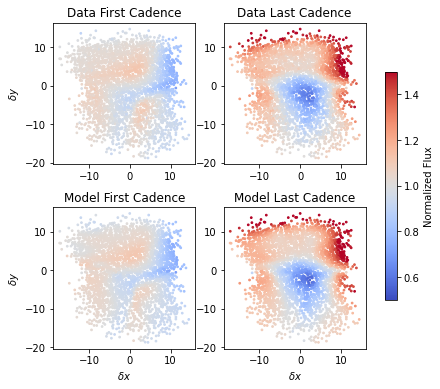

In [13]:
machine.time_corrector = "plynomial"
machine.build_time_model(plot=True);

We can also use the `pos_corr`'s as basis:

using pos_corrs
using pos_corrs


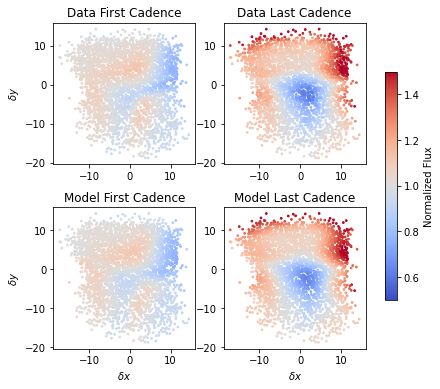

In [14]:
machine.time_corrector = "pos_corr"
machine.n_time_points = 100
machine.cartesian_knot_spacing = "sqrt"
machine.n_time_knots = 6
machine.build_time_model(plot=True);

This figure is very similar when using the time model, but later we'll see that light curves generated with this corrector have less "general trend" 
when compared to the time polynomial.

Lets visualize this `pos_corr`'s vectors:

In [15]:
machine._whitened_time.shape, machine.pos_corr1_smooth.shape, np.nanmedian(machine.pos_corr1, axis=0).shape

((4486,), (4486,), (4486,))

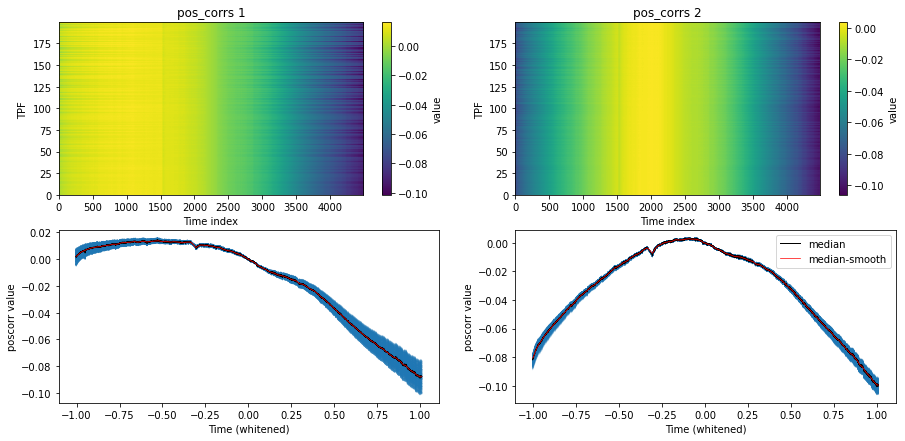

In [16]:
fig, ax = plt.subplots(2,2, figsize=(15, 7))
ax[0,0].set_title("pos_corrs 1")
cbar = ax[0,0].imshow(machine.pos_corr1, aspect="auto", origin="lower", interpolation=None)
ax[0,0].set_xlabel("Time index")
ax[0,0].set_ylabel("TPF")
fig.colorbar(cbar, ax=ax[0,0], label="value")

ax[0,1].set_title("pos_corrs 2")
cbar = ax[0,1].imshow(machine.pos_corr2, aspect="auto", origin="lower", interpolation=None)
ax[0,1].set_xlabel("Time index")
ax[0,1].set_ylabel("TPF")
fig.colorbar(cbar, ax=ax[0,1], label="value")


for k in range(machine.pos_corr1.shape[0]):
    ax[1,0].plot(machine._whitened_time, machine.pos_corr1[k], alpha=.2, lw=1, c="tab:blue")
    ax[1,1].plot(machine._whitened_time, machine.pos_corr2[k], alpha=.2, lw=1, c="tab:blue")

ax[1,0].plot(machine._whitened_time, np.nanmedian(machine.pos_corr1, axis=0), c="k", lw=1, label="median")
ax[1,0].plot(machine._whitened_time, machine.pos_corr1_smooth, c="r", ls="-", lw=.7, label="median-smooth")
ax[1,0].set_xlabel("Time (whitened)")
ax[1,0].set_ylabel("poscorr value")

ax[1,1].plot(machine._whitened_time, np.nanmedian(machine.pos_corr2, axis=0), c="k", lw=1, label="median")
ax[1,1].plot(machine._whitened_time, machine.pos_corr2_smooth, c="r", ls="-", lw=.7, label="median-smooth")
ax[1,1].set_xlabel("Time (whitened)")
ax[1,1].set_ylabel("poscorr value")
ax[1,1].legend(loc="best")
plt.show()

The top panels shows the `pos_corr1` and `pos_corr2` vectors for all TPFs (y axis) as a function of time.
The bottom panels also shows the median (black) value for each vector and a smooth version of the median which is used as basis to correct the source position drift.

## PSF photometry

Now with our shape and time model we can get PSF photometry. This is done using `machine.fit_model()` method that has the option
to use or not the "time model" by passing the `fit_va` flag.
This will create the following new attributes:
* `ws` and `werrs` have the uncorrected PSF flux and flux errors.
* `ws_va` and `werrs_va` have the PSF flux and flux errors corrected by velocity aberration.

In [17]:
machine.fit_model(fit_va=True)

Fitting 359 Sources (w. VA): 100%|██████████| 4486/4486 [03:53<00:00, 19.20it/s]


## Aperture Masks

`PSFMachine` can also do Aperture Photometry (aka SAP) with custom aperture masks. We use the PSF profile to define the aperture shapes, this is done
by evaluating the PSF on a source and using isophotes to define the aperture boundaries The parameter that controls the aperture size
is the percentile of the distribution values for the PSF model evaluated on a source. We find this parameter by
optimizing two metrics:
* **FLFRCSAP**: the fraction of target flux contained in the photometric aperture over the total target flux
* **CROWDSAP**: the ratio of target flux relative to the total flux within the photometric aperture including contaminating sources

We use the evaluated PSF model on all sources to compute these metrics simultaneously for all of them.

To compute SAP we use `machine.compute_aperture_photometry()` with parameters:
* `aperture_size` if `'optimal'` it will optimize the aperture to achieve the target flux metrics, if int `[0, 100]` will use the flux value
  at the provided percentile as isophote.
* `target_complete` target FLFRCSAP metric, valid values are between `[0, 1]`
* `target_crowd` target CROWDSAP metric, valid values are between `[0, 1]`

This will create the following attribuites:
* `aperture_mask` the pixel mask for each source, shape is `[n_sources, n_pixels]`
* `FLFRCSAP` and `CROWDSAP` with the resulting flux metrics for each source, shape is `[n_sources]`
* `sap_flux` and `sap_flux_err` with the flux and error values for each sources all times, shape is `[n_times, n_sources]`

In [18]:
machine.compute_aperture_photometry(aperture_size="optimal", target_complete=1, target_crowd=1)

SAP: 100%|██████████| 359/359 [00:00<00:00, 393.61it/s]


We can check how the flux metrics changes as a function of the aperture size (percentile) and where is the aperture found by the 
optimization. This figure also serves as an insight for users to choose their own `percentile` parameter, in case of wanting a
different aperture and flux metrics.

In [19]:
from psfmachine.aperture import plot_flux_metric_diagnose

<AxesSubplot:xlabel='Percentile', ylabel='Metric'>

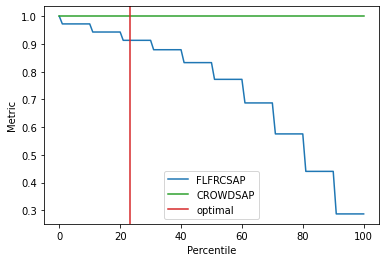

In [20]:
# idx is the source index in `machine.source`
# optimal_percentile is an optional argument in case aperture_size=="optimal" in 
# machine.compute_aperture_photometry()
plot_flux_metric_diagnose(machine.mean_model, idx=0, optimal_percentile=machine.optimal_percentile[0])

## Source positions

`PSFMachine` includes multiple options to get the source positions (centroids), This is done with the `machine.get_source_centroids()` method
that accepts the `method` parameter which can be:
* `"aperture"` it uses the aperture mask and pixel fluxes to compute momentum centroids.
* `"poscor"` it uses the Gaia RA and Dec values converted to pixel coordinates with the TPF's WCS solutions and corrected by the `pos_corr`'s.
* `"scene"` it uses the Gaia RA and Dec values converted to pixel coordinates with the TPF's WCS solutions and corrected by the scene centroids computed in `machine._get_centroids()`.

Default is `'poscor'`. Each method creates new attributes, so you can run multiple methods and keep all results:
* `source_centroids_column_ap` and `source_centroids_row_ap` with the centroids of aperture method. By definition, this will return int values if the source got 1-pixel aperture.
* `source_centroids_column_poscor` and `source_centroids_row_poscor` with the centroids of `pos_corr` method.
* `source_centroids_column_scene` and `source_centroids_row_scene` with the centroids of `scene` method.

In [21]:
machine.get_source_centroids(method="aperture")
machine.get_source_centroids(method="poscor")
machine.get_source_centroids(method="scene")

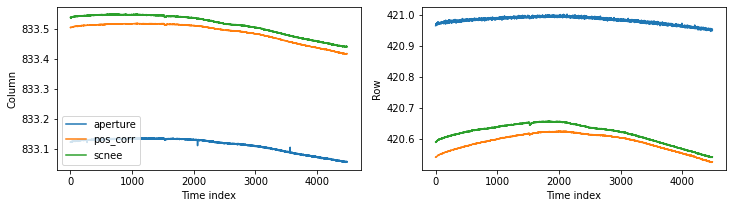

In [22]:
fix, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(machine.source_centroids_column_ap[0], label="aperture")
ax[0].plot(machine.source_centroids_column_poscor[0], label="pos_corr")
ax[0].plot(machine.source_centroids_column_scene[0], label="scnee")
ax[1].plot(machine.source_centroids_row_ap[1])
ax[1].plot(machine.source_centroids_row_poscor[1])
ax[1].plot(machine.source_centroids_row_scene[1])
ax[0].legend(loc="lower left")
ax[0].set_xlabel("Time index")
ax[0].set_ylabel("Column")
ax[1].set_xlabel("Time index")
ax[1].set_ylabel("Row")
plt.show()

## Create Light Curves

To create light curves, we just have to do `self.fit_lightcurves()`. This method will fit a PSF model to all the sources available simultaneously,
fit a time polynomial to remove velocity aberration from the scene, and will use these two model to obtain the PSF flux. Also, the method will
do aperture photometry (SAP) on all sources where each aperture is defined accordingly to the PSF profile.
Setting `plot=True` will show diagnostic plots for the PSF model and the time model.

This method runs all the above mentioned photometry methods with default parameters and will create the new attribute `self.lcs` with light curves as `lk.LightCurveCollection` object.

SAP: 100%|██████████| 359/359 [00:01<00:00, 283.12it/s]


using pos_corrs
using pos_corrs


Fitting 359 Sources (w. VA): 100%|██████████| 4486/4486 [05:28<00:00, 13.67it/s]


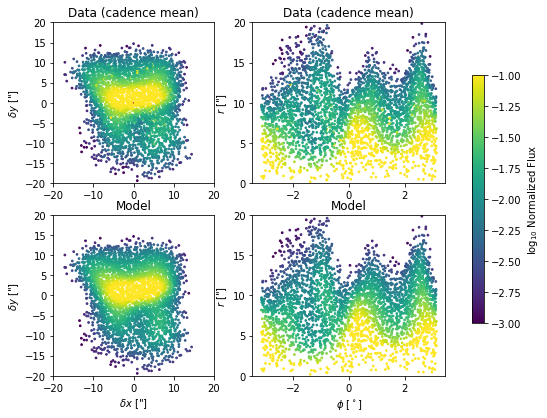

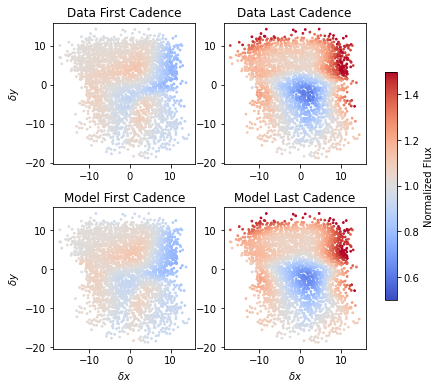

In [23]:
machine.fit_lightcurves(plot=True)

Let's see our new light curves:

In [24]:
machine.lcs[0]

time,flux,flux_err,psf_flux_NVA,psf_flux_err_NVA,sap_flux,sap_flux_err
,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s
object,float64,float64,float64,float64,float64,float64
2455276.4906453583,6833.765011523716,5.544842105145988,6905.667454065471,5.614130953324965,3809.272216796875,3.4859983921051025
2455276.5110794757,6838.077911857233,5.544577180540986,6909.905508383375,5.613885333060158,3817.490234375,3.4867238998413086
2455276.531513393,6835.016881359948,5.545089948823821,6907.127521786931,5.614478722322573,3814.421630859375,3.487135648727417
2455276.5519474107,6827.238002635338,5.5440620072415125,6898.244216830317,5.613376813036338,3808.90185546875,3.486121416091919
2455276.572381528,6838.376406425427,5.544495970897896,6910.4220583813185,5.614097090177775,3815.55859375,3.4869210720062256
2455276.592815446,6829.169126825524,5.544283394894584,6900.915758531288,5.613936529638231,3808.21142578125,3.485898971557617
2455276.613249464,6842.263700019334,5.544751337133349,6914.956095707581,5.614681077551873,3815.16943359375,3.4863038063049316
2455276.6336835823,6826.378577124188,5.542675757139697,6899.574483860551,5.612877436771392,3806.777587890625,3.4854536056518555


The `lightkurve` object has 7 columns:
    * `time`: the observing time in MJD
    * `flux` and `lux_err`: have the PSF photometry corrected for velocity aberration
    * `flux_NVA` and `lux_err_NVA`: have the PSF photometry without correction for velocity aberration
    * `sap_flux` and `sap_lux_err`: have the aperture photometry
    
Because each element in `self.lcs` is a `lightkurve.LightKurve` object, we can use all the functionalities the library
offers, like plotting, saving to FITS, doing periodograms, etc.

### Inspecting the Light Curves

After we got all the new light curves, we can inspect them using `mahcine.plot_tpf()` method which will show 
the light curves of all sources detected in a given TPF, the TPF itself with Kepler's pipeline aperture, the PSF 
models for each source and our own aperture masks for each source.

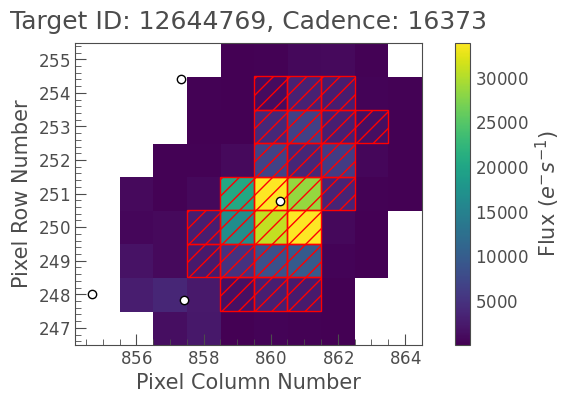

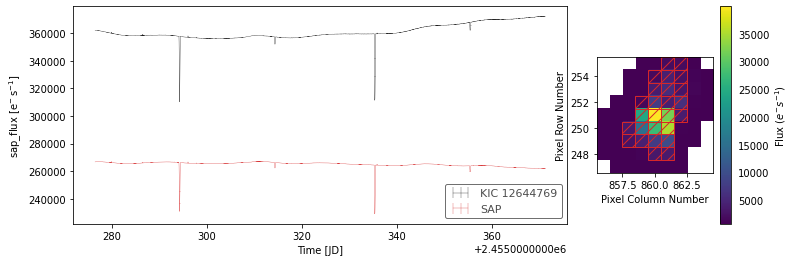

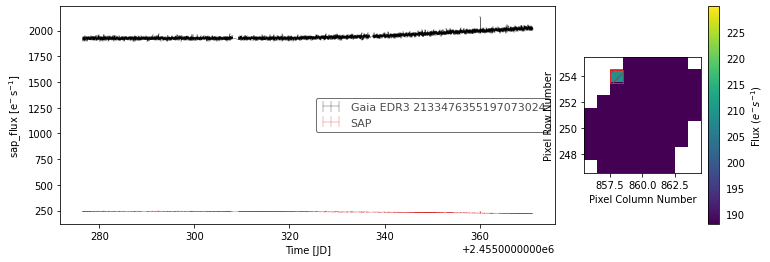

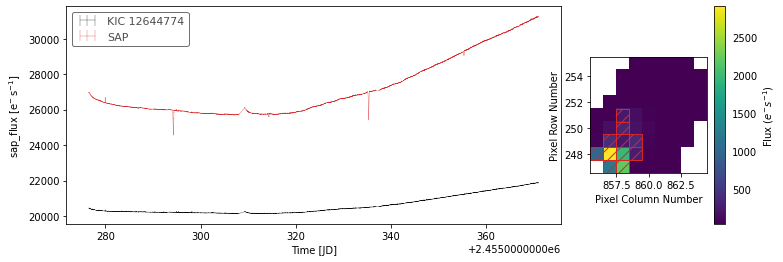

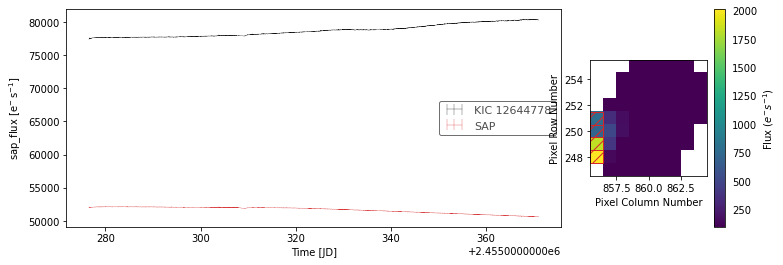

In [25]:
machine.plot_tpf(0, sap=True)

The first panel shows the TPF, Kepler's aperture, and sources on the TPF. The following panels show the PSF (black) and SAP (red) photometry for each source
on the TPF, as well as the evaluated PSF model and the aperture computed by `PSFMachine`.

In this case, the 3rd source at the bottom left got a slightly contaminated aperture including signal from the central target. This can be seen on the SAP (red) light curve that shows
an eclipse but the PSF (black) does not. This can be improved by choosing a smaller aperture for that particular source.

Note that PSF photmetry is generally larger than SAP (for sources fully on sensor), this is because during PSF fitting we use the Gaia g flux as prior, but Kepler's band is 
slightly different than Gaia's g band. Although, this is just a zero point correction that can be added later to obtain the absolute
flux and doe not interfere when doing relative photometry work.